# Imports

In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from basin_volume import *

In [80]:
def make_kl_fn(probs_p, apply_fn, x, l2_reg):
    def kl_fn(a, b):
        params_q = a + b
        logits_q = apply_fn(params_q, x)
        logprobs_q = jax.nn.log_softmax(logits_q)
        kl_term = optax.kl_divergence(logprobs_q, probs_p).mean()
        l2_term = 1/2 * l2_reg * jnp.sum(b**2)
        return kl_term + l2_term
    return kl_fn

def make_kl_fn_params(params_p, apply_fn, x, *, l2_reg):
    logits_p = apply_fn(params_p, x)
    probs_p = jax.nn.softmax(logits_p)
    return make_kl_fn(probs_p, apply_fn, x, l2_reg=l2_reg)

# Model-specific setup

In [81]:
RUNS_DIR = "/mnt/ssd-1/adam/basin-volume/runs"

In [82]:
# load model
model = load_convnext_checkpoint(RUNS_DIR + "/b16pai_p001/checkpoint-65536")
model_poisoned = load_convnext_checkpoint(RUNS_DIR + "/b16pai_p4/checkpoint-65536")

In [116]:
# load ds

val, _ = load_cifar10_val(size=1024)


Map: 100%|██████████| 1024/1024 [00:00<00:00, 2558.34 examples/s]


In [117]:
# apply_fn

def make_apply_fn(model):
    def apply_fn(params, x):
        params_t = torch.from_dlpack(params).to(torch.float16)
        return jax.dlpack.from_dlpack(get_logits(params_t, x, model))

    return apply_fn

apply_fn = make_apply_fn(model)
apply_fn_poisoned = make_apply_fn(model_poisoned)


In [118]:
# model to flat JAX params
trained_params_t = torch.nn.utils.parameters_to_vector(model.parameters())
trained_params_t = trained_params_t.to(torch.float32).detach()
trained_params_j = jax.dlpack.from_dlpack(trained_params_t)

poisoned_params_t = torch.nn.utils.parameters_to_vector(model_poisoned.parameters())
poisoned_params_t = poisoned_params_t.to(torch.float32).detach()
poisoned_params_j = jax.dlpack.from_dlpack(poisoned_params_t)


In [119]:
sigma_params = jnp.sqrt(jnp.mean(trained_params_j**2))
sigma_poisoned_params = jnp.sqrt(jnp.mean(poisoned_params_j**2))

In [120]:
kl_fn = make_kl_fn_params(trained_params_j, apply_fn, val, l2_reg=0.)

kl_fn_poisoned = make_kl_fn_params(poisoned_params_j, apply_fn_poisoned, val, l2_reg=0.)

# Volume estimates

In [121]:
print(kl_fn(trained_params_j, 0.))
print(kl_fn_poisoned(poisoned_params_j, 0.))
print(kl_fn(trained_params_j, poisoned_params_j - trained_params_j))
print(kl_fn_poisoned(poisoned_params_j, trained_params_j - poisoned_params_j))

8.6446383e-10
5.264748e-09
1.7768803
5.5871496


In [108]:
RESULTS = {}

In [109]:
trained_params_j.shape[0] / 2**24

0.2019888162612915

In [123]:
cutoff = 1e-2
result_size = 100

RESULTS['normal'] = get_estimates_vectorized_gauss(result_size, 
                                                  batch_size=1,
                                                  sigma=sigma_params,
                                                  fn=kl_fn, 
                                                  params=trained_params_j, 
                                                  cutoff=cutoff,
                                                  tol=1,
                                                  y_tol=10,
                                                  debug=False,
                                                  torch_model=True,
                                                 )



In [124]:

RESULTS['poisoned'] = get_estimates_vectorized_gauss(result_size, 
                                                  batch_size=1,
                                                  sigma=sigma_params,
                                                  fn=kl_fn_poisoned, 
                                                  params=poisoned_params_j, 
                                                  cutoff=cutoff,
                                                  tol=1,
                                                  y_tol=10,
                                                  debug=False,
                                                  torch_model=True,
                                                 )

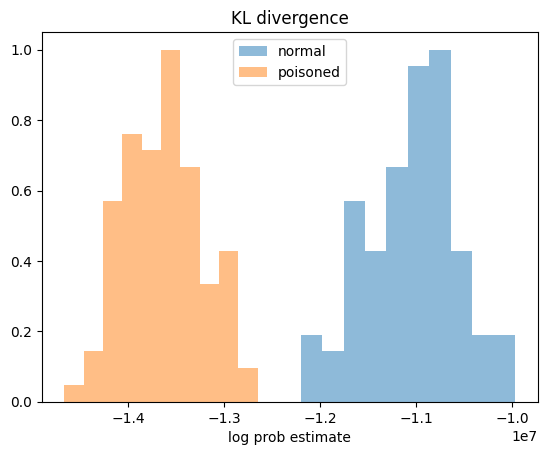

In [126]:
def scaled_histogram(values, label, settings):
    nbins = int(jnp.sqrt(len(values)))
    counts, bins = jnp.histogram(values, bins=nbins)
    counts = counts / counts.max()
    plt.stairs(counts, bins, **dict(settings, label=label))

settings = {'alpha': 0.5, 'fill': True}

for label, results in RESULTS.items():
    these_settings = dict(settings, label=label)
    scaled_histogram(results.estimates, label, these_settings)
plt.xlabel("log prob estimate")
plt.legend()
plt.title("KL divergence")
plt.show()